In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
!pip install torch torchvision torchaudio scikit-learn

In [4]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d shayanfazeli/heartbeat

Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
heartbeat.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip heartbeat.zip

Archive:  heartbeat.zip
replace mitbih_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: mitbih_test.csv         
replace mitbih_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: mitbih_train.csv        yes

replace ptbdb_abnormal.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: ptbdb_abnormal.csv      
replace ptbdb_normal.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: ptbdb_normal.csv        


In [8]:
# Load the training and test data
train_df = pd.read_csv("mitbih_train.csv", header=None)
test_df = pd.read_csv("mitbih_test.csv", header=None)

In [9]:
# Split features and labels
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

In [10]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Normalize
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

In [13]:
# Add channel dimension
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

In [14]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (87554, 1, 187)
Test shape: (21892, 1, 187)


In [15]:
# Custom Dataset
class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = torch.tensor(signals, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

In [16]:
# Create Dataset objects
train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

In [17]:
# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
class ECG1DCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(ECG1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.flattened_size = 64 * 46

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool2(nn.ReLU()(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [20]:
model = ECG1DCNN(num_classes=5).to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f}")


In [23]:
train_model(model, train_loader, criterion, optimizer, device, num_epochs=10)

Epoch 1/10 | Loss: 0.1611
Epoch 2/10 | Loss: 0.1007
Epoch 3/10 | Loss: 0.0843
Epoch 4/10 | Loss: 0.0713
Epoch 5/10 | Loss: 0.0644
Epoch 6/10 | Loss: 0.0571
Epoch 7/10 | Loss: 0.0524
Epoch 8/10 | Loss: 0.0476
Epoch 9/10 | Loss: 0.0426
Epoch 10/10 | Loss: 0.0406


In [24]:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

preds, true_labels = evaluate_model(model, test_loader, device)


In [25]:
# Classification report
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.94      0.74      0.83       556
           2       0.96      0.95      0.95      1448
           3       0.86      0.73      0.79       162
           4       1.00      0.98      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.95      0.88      0.91     21892
weighted avg       0.98      0.98      0.98     21892



In [26]:
# Confusion matrix
cm = confusion_matrix(true_labels, preds)

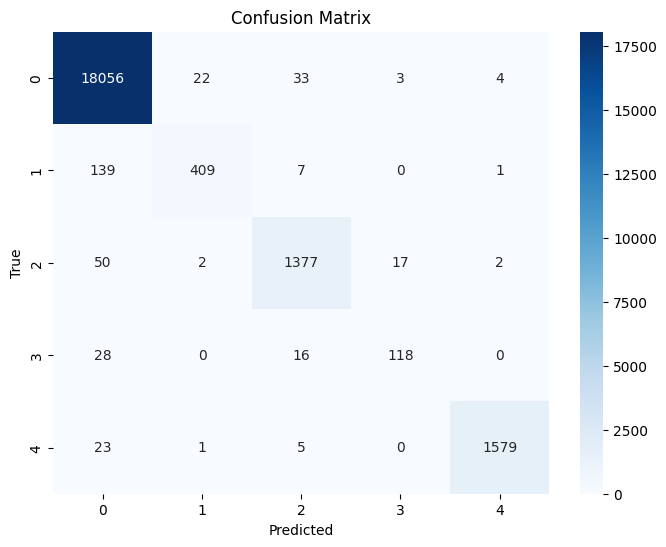

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [28]:
torch.save(model.state_dict(), "ecg_cnn.pth")

In [29]:
from google.colab import files
files.download("ecg_cnn.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>